In [12]:
import torch
import numpy as np
import pyro
import pyro.distributions as dist
from pyro.ops.indexing import Vindex
from pyro import poutine
import matplotlib.pyplot as plt
import torch.distributions.constraints as constraints
from torch.distributions import transform_to
from pyro.infer import MCMC, NUTS
from pyro.poutine.messenger import Messenger


In [40]:
import os
import sys
import inspect

# insert root dir into sys
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
root_dir = os.path.dirname(currentdir)
# print(root_dir)

if root_dir not in sys.path:
     sys.path.insert(0, root_dir)

In [41]:
import sim3

In [30]:
def model():
    # with pyro.plate("plate0", size=len(obs)) as ind:
    a = pyro.sample("a", dist.Uniform(0, 1))
    b = pyro.sample("b", dist.Uniform(0, 1))
    c = pyro.sample("c", dist.Uniform(0, 1))
    # c = pyro.sample("c", dist.Bernoulli(b), obs=obs.index_select(0, ind))
    pyro.deterministic("sum", a+b+c)
    
    log_score_a = torch.tensor(-np.inf) if a <= 0.5 else torch.tensor(0.)
    # pyro.factor("a1", log_score_a)
    
    log_score_b = torch.tensor(-np.inf) if b <= 0.5 else torch.tensor(0.)
    # pyro.factor("b1", log_score_b)


In [31]:
def train(model, steps):
    nuts_kernel = NUTS(model)
    mcmc = MCMC(
            nuts_kernel,
            num_samples=steps,
            # warmup_steps=1,
            num_chains=1,)

    # with ResultCollectorMessenger() as res:
    mcmc.run()
    # mcmc.run(torch.ones(3))
    print(mcmc.summary())
    return(mcmc)


In [32]:
pyro.clear_param_store()
imcmc=train(model, 300)

Sample: 100%|██████████| 600/600 [00:21, 27.82it/s, step size=7.74e-01, acc. prob=0.896]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.50      0.30      0.49      0.02      0.90    203.73      1.00
         b      0.53      0.26      0.52      0.16      0.98    293.48      1.00
         c      0.49      0.28      0.47      0.04      0.91    306.63      1.00

Number of divergences: 0
None


Results of `sum` from 0 to 3:

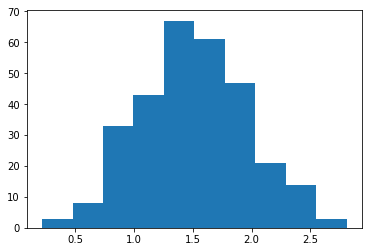

In [34]:
a = imcmc.get_samples()['a']
b = imcmc.get_samples()['b']
c = imcmc.get_samples()['c']
# plt.plot(b)
# plt.show()
plt.hist(a+b+c)
plt.show()

If factor to `a` and `b` added, then results of `sum` will $\in$ (1, 3)

In [35]:
def model1():
    # with pyro.plate("plate0", size=len(obs)) as ind:
    a = pyro.sample("a", dist.Uniform(0, 1))
    b = pyro.sample("b", dist.Uniform(0, 1))
    c = pyro.sample("c", dist.Uniform(0, 1))
    # c = pyro.sample("c", dist.Bernoulli(b), obs=obs.index_select(0, ind))
    pyro.deterministic("sum", a+b+c)
    
    log_score_a = torch.tensor(-np.inf) if a <= 0.5 else torch.tensor(0.)
    pyro.factor("a1", log_score_a)
    
    log_score_b = torch.tensor(-np.inf) if b <= 0.5 else torch.tensor(0.)
    pyro.factor("b1", log_score_b)


Sample: 100%|██████████| 600/600 [01:32,  6.52it/s, step size=4.94e-02, acc. prob=0.901]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.76      0.15      0.76      0.55      1.00     32.25      1.02
         b      0.63      0.09      0.64      0.50      0.75     14.22      1.07
         c      0.48      0.27      0.47      0.03      0.84     33.10      1.01

Number of divergences: 276
None


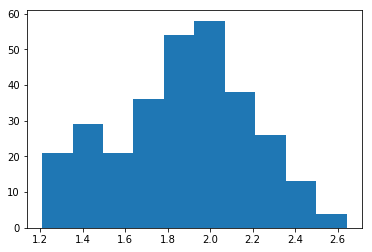

In [37]:
pyro.clear_param_store()
imcmc=train(model1, 300)
a = imcmc.get_samples()['a']
b = imcmc.get_samples()['b']
c = imcmc.get_samples()['c']
# plt.plot(b)
# plt.show()
plt.hist(a+b+c)
plt.show()

so it does

Same result for the Rejection Sampling:

In [42]:
def model_cond(trace):
    return (trace.nodes["a"]["value"]>0.5) and (trace.nodes["b"]["value"]>0.5)

progress: █████████ 99 %
done
create df:: █████████ 98 %
done
making arrays for plot:: █████████ 98 %
done
var:  sum
probabilties:
[0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333]


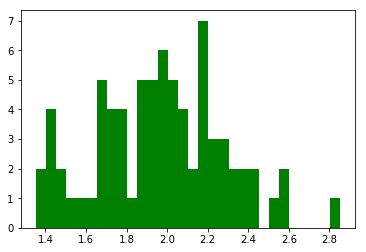

,a,b,c,sum,cond
2,0.5453422,0.7198144,0.112730205,1.3778868,True
0,0.8677343,0.60273,0.2300384,1.7005026,True
9,0.53187937,0.6489145,0.7102233,1.8910172,True
8,0.8949633,0.6723767,0.409566,1.9769061,True
3,0.5031156,0.72300833,0.79924816,2.025372,True
7,0.6867624,0.55057895,0.9403866,2.177728,True
4,0.7503402,0.74222994,0.69745505,2.1900253,True
5,0.7726116,0.6200946,0.8267546,2.2194607,True
1,0.5593931,0.9716894,0.74454385,2.2756264,True
6,0.62596,0.9498519,0.8652796,2.4410915,True


In [67]:
samples = sim3.rejection_sampling1(model, {}, model_cond, 300)
df = sim3.make_dataFrame(samples)
sim3.plot_results1(samples, "sum")
df[:10].sort_values("sum", ascending=True)

so the `sum` values starting from 1 also.